# Ontario COVID19 Cases Forecasting

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import seaborn as sns
import datetime as dt
from matplotlib.pyplot import figure
from sklearn import metrics
import itertools
import statsmodels.api as sm
import pmdarima as pm

## Import data

#### Comfirmed in Ontario

In this project, Ontario is selected as the targeted location for exploration, since I am interested in the area that I am currently living at.

In [2]:
df = pd.read_csv('time_series_covid19_confirmed_global.csv')
df_on = df.loc[df['Province/State'] == 'Ontario']
df_on_con = df_on
df_on

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,12/1/20,12/2/20,12/3/20,12/4/20,12/5/20,12/6/20,12/7/20,12/8/20,12/9/20,12/10/20
49,Ontario,Canada,51.2538,-85.3232,0,0,0,0,1,1,...,121770,123639,125233,127130,128997,130962,132736,134605,136599,138529


#### Death in Ontario

In [3]:
df_de = pd.read_csv('time_series_covid19_deaths_global.csv')
df_on_de = df_de.loc[df_de['Province/State'] == 'Ontario']
df_on_de

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,12/1/20,12/2/20,12/3/20,12/4/20,12/5/20,12/6/20,12/7/20,12/8/20,12/9/20,12/10/20
49,Ontario,Canada,51.2538,-85.3232,0,0,0,0,0,0,...,3680,3714,3727,3759,3774,3794,3816,3827,3861,3891


## Part 1. Data Cleaning

Detailed steps in the data cleaning pipeline are listed as follows:

    1.Drop non numerical columns.Only Covid case data is kept.
    2.Convert data type of date from object to datetime
    3.Transpose the data to make datetime as index of rows
    4.Rename the column
    5.Add frequency to datetime
    
All data cleaning and preprocessing steps are for the purpose of data preparation of time series model.(i.e. ARIMA)

In [4]:
# Drop non numerical columns
cols = ['Province/State','Country/Region','Lat', 'Long']
df_on.drop(cols, axis=1, inplace=True)

# Preprocessing for time series projection 
df_on.columns = pd.to_datetime(df_on.columns) # Convert date to datetime type
df_on = df_on.T # Transpose the data
df_on.columns = ['history_ON'] # Rename the column
df_on.index = pd.DatetimeIndex(df_on.index.values, freq=df_on.index.inferred_freq) # Add frequency to datetime
df_on

C:\Users\dell\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,history_ON
2020-01-22,0
2020-01-23,0
2020-01-24,0
2020-01-25,0
2020-01-26,1
...,...
2020-12-06,130962
2020-12-07,132736
2020-12-08,134605
2020-12-09,136599


## Part 2. Data Visualization and Exploratory Data Analysis

### Daily new cases of COVID-19 in Ontario

From the trend of daily new cases, the overall situation of COVID-19 in Ontario can be visualized more intuitively. As shown in this figure, two peaks corresponds to the first and second wave of pandemic, and we are still in the progress of the second wave pandemic. 

The influences of policies on the pandemic in Ontario are illustrated and discussed more in detail according to the cumulative death number plotted in the third visualization in this section. And this figure is an important reference to help relate the Covid-19 cases to the second dataset, which will be explained particularly in Part 4. 

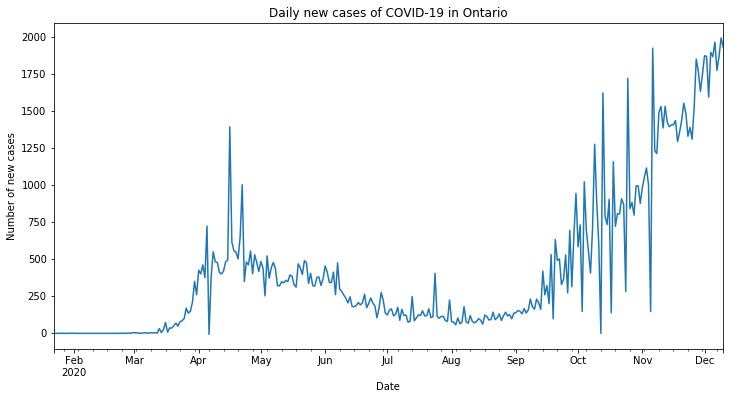

In [5]:
ax = df_on.diff(axis=0).plot(figsize=(12, 6),
                             title = 'Daily new cases of COVID-19 in Ontario')
ax.set_xlabel("Date")
ax.set_ylabel("Number of new cases")
ax.get_legend().remove()

### Cumulative cases of COVID-19 in all provinces of Canada

Here, the cumulative numbers of COVID-19 cases in different provinces of Canada are plotted. As shown, the pandemic situation in Ontario is the second worst in Canada. By comparing the curves of different provinces, we can conclude that the trend of pandemic is similar all over Canada, especially for the provinces that have a large number of confirmed cases. Notice that the case number in British Columbia is relatively small compared to its large populations. Therefore, it is worth to explore the reasons behind this and learn from it. The detailed analysis about this aspect will be conducted in Part 5.

Text(0, 0.5, 'Number of cases')

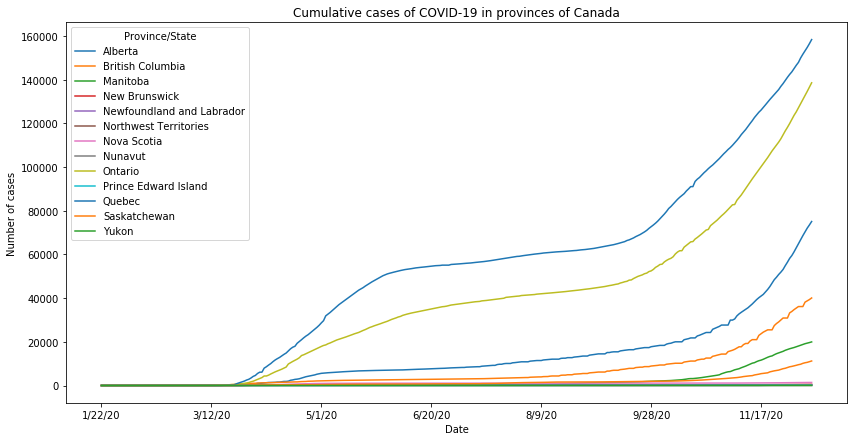

In [6]:
df_ca = df.loc[df['Country/Region'] == 'Canada']
df_ca.index = df_ca['Province/State']
df_ca = df_ca.drop(['Diamond Princess','Grand Princess','Repatriated Travellers'],axis=0)
ax = df_ca.transpose().iloc[4:].plot(figsize=(14, 7),
                                     title = 'Cumulative cases of COVID-19 in provinces of Canada')
ax.set_xlabel("Date")
ax.set_ylabel("Number of cases")

### Cumulative deaths from COVID-19 in Ontario

In this figure, the culmulative death from COVID-19 in Ontario is plotted. Compared to the confirmed cases, the government should pay more attention to the deaths number. As shown, the cumulative death has increased dramatically from April, corresponding to the first wave of pandemic. Till the start of July, thanks to the policies of the lockdown, social distance, etc., there was approximately no more death. In this case, the lockdown has partially ended at that time and most public place reopened. When it came to Octomber, the second wave pandemic was coming due to the negligence of some Ontario residents, so the number of death started increasing again.

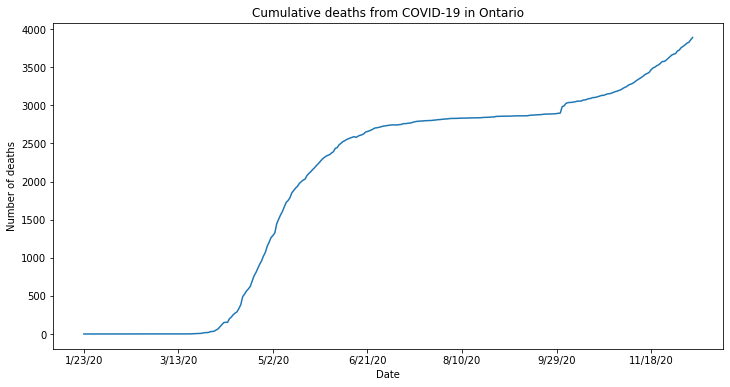

In [7]:
ax = df_on_de.transpose().iloc[5:].plot(figsize=(12, 6),
                                        title = 'Cumulative deaths from COVID-19 in Ontario')
#df_on_con.transpose().iloc[5:].plot(ax = ax)
ax.set_xlabel("Date")
ax.set_ylabel("Number of deaths")
ax.get_legend().remove()

## Part 3.Model selection and fitting to data

### Data split

First 85% data is split into training set and the rest is for testing in order to capture the features of 2nd wave of pandemic.

In [8]:
df_train, df_test= np.split(df_on, [int(0.85 *len(df_on))])

### Model selection - ARIMA

To generate projections of time series data, ARIMA is selected as the model. ARIMA is short for Auto Regressive Integrated Moving Average. It is a statistical model that can fit a given time series based on its own lags and the lagged forecast errors, then forecast future projections.

Basically, ARIMA model is characterized by 3 terms: p, d, q

- p stands for the order of the AR term
- d stands for the number of differencing required to make the time series stationary
- q stands for the order of the MA term

By allowing these parameters and if further tuning, ARIMA is able to fit the time series with a high accuracy. ARIMA can also handle seasonal patterns by including seasonal terms if the time series has seasonal patterns. Supported by the reasons above, ARIMA is a easy-to-use and robust model for time series forecasting. Therefore, it is selected to predict the Covid cases in the future. 

In the following sections, the approaches to determine the optimal model and the methodology to generate 3 cases of projection will be explained in detail.

### No seasonal pattern

At first, no seasonal pattern is introduced into the model. 

#### Hyperparameter tuning

In order to obtain the base-case spread projection that fits the data optimally, models with different combinations of p,d and q are implemented for hyperparameter tuning. In the tuning, we are searching for the best model that minimizes AIC, which is an estimator of out-of-sample prediction error representing the quality of model fitting. From hyperparameter tuning, the optimal result is given by ARIMA(3,2,2).

In [9]:
smodel = pm.auto_arima(df_train, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=1,
                         start_P=0, seasonal=False,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=3526.603, Time=0.22 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=3713.667, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=3609.192, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=3536.698, Time=0.13 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=3711.732, Time=0.01 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=3525.107, Time=0.28 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=3577.620, Time=0.06 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=3516.515, Time=0.35 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=3551.571, Time=0.10 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=3505.883, Time=0.54 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=3511.547, Time=0.56 sec
 ARIMA(3,2,3)(0,0,0)[0] intercept   : AIC=3506.615, Time=0.81 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.68 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=3505.679, Time=0.26 sec
 ARIMA(2,2,2)(0,0,0)[0]             : 

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  275
Model:               SARIMAX(3, 2, 2)   Log Likelihood               -1746.839
Date:                Mon, 14 Dec 2020   AIC                           3505.679
Time:                        00:15:06   BIC                           3527.335
Sample:                             0   HQIC                          3514.372
                                - 275                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1526      0.107      1.423      0.155      -0.058       0.363
ar.L2         -0.2024      0.070     -2.877      0.004      -0.340      -0.064
ar.L3         -0.2485      0.061     -4.100      0.000      -0.367      -0.130
ma.L1         -1.2122      0.112    -10.846      0.000      -1.431      -0.993
ma.L2          0.5530      0.083      6.697      0.000       0.391       0.715
sigma2      2.103e+04    750.662     28.009      0.000    1.96e+04    2.25e+04
===================================================================================
Ljung-Box (Q):                       50.37   Jarque-Bera (JB):              1958.59
Prob(Q):                              0.13   Prob(JB):                         0.00
Heteroskedasticity (H):               1.95   Skew:                             1.04
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Model fitting and prediction

In [10]:
mod = sm.tsa.statespace.SARIMAX(df_train,
                                order=(3, 2, 2),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit(maxiter = 5000, method='nm')
print(results.summary().tables[1])

Optimization terminated successfully.
         Current function value: 6.286613
         Iterations: 429
         Function evaluations: 671
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1353      0.110      1.232      0.218      -0.080       0.351
ar.L2         -0.2091      0.070     -2.984      0.003      -0.346      -0.072
ar.L3         -0.2508      0.062     -4.064      0.000      -0.372      -0.130
ma.L1         -1.1972      0.115    -10.449      0.000      -1.422      -0.973
ma.L2          0.5406      0.085      6.369      0.000       0.374       0.707
sigma2      2.128e+04    768.585     27.682      0.000    1.98e+04    2.28e+04


The best model is fitted to training set and the in-sample prediction result is shown in the figure below. As shown, there is a moderate difference between the curve of the test data and the prediction.

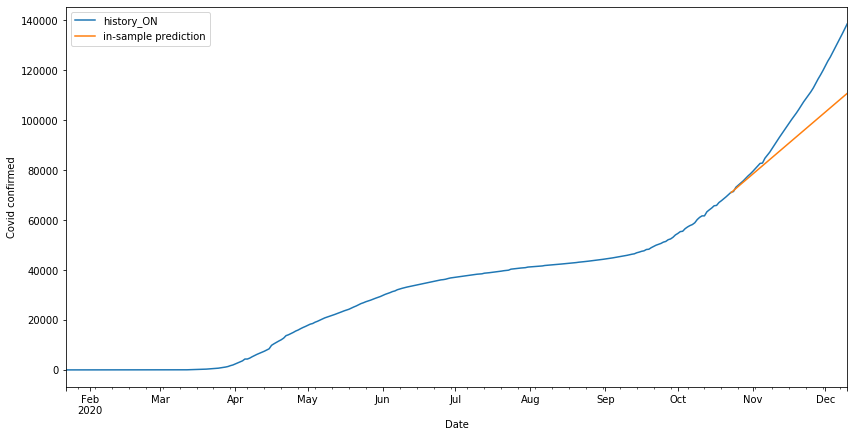

In [11]:
pred = results.get_prediction(start=pd.to_datetime('2020-10-23'),end=pd.to_datetime('2020-12-10'), dynamic=False)
pred_ci = pred.conf_int()
ax = df_on.plot()
pred.predicted_mean.plot(ax=ax, label='in-sample prediction',figsize=(14, 7))
ax.set_xlabel('Date')
ax.set_ylabel('Covid confirmed')
plt.legend()
plt.show()

#### Selection of evaluation metric

MAPE is a popular metric used in forecasting systems, so it is chosen as the metric to evaluate the model. As demonstrated, MAPE of this prediction is 0.083, which is still not an optimal value. 

In [12]:
actual = df_test.values.reshape(-1)
forecast = pred.predicted_mean.values
mape = np.mean(np.abs(forecast - actual)/np.abs(actual))
mape

0.08332110609886936

By combining both graphical and numerical resutls mentioned, it is concluded that the model is still not optimal and new methods will be introduced in next section.

### Seasonal patterns

As stated, the model cannot be optimized by simply tuning of p, d and q. In order to further improve the model accuracy, seasonal patterns are introduced to build models in this section. 

#### Hyperparameter tuning

The parameter of new models with seasonal pattersn are also tested by hyperparameter tuning. The optimal model parameters with seasonal patterns are ARIMA(3,2,3)(2,1,0)[12].

In [13]:
smodel = pm.auto_arima(df_train, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,1,1)[12]             : AIC=inf, Time=0.58 sec
 ARIMA(0,2,0)(0,1,0)[12]             : AIC=3678.960, Time=0.03 sec
 ARIMA(1,2,0)(1,1,0)[12]             : AIC=3543.864, Time=0.20 sec
 ARIMA(0,2,1)(0,1,1)[12]             : AIC=inf, Time=0.40 sec
 ARIMA(1,2,0)(0,1,0)[12]             : AIC=3593.245, Time=0.04 sec
 ARIMA(1,2,0)(2,1,0)[12]             : AIC=3520.111, Time=0.64 sec
 ARIMA(1,2,0)(2,1,1)[12]             : AIC=inf, Time=1.99 sec
 ARIMA(1,2,0)(1,1,1)[12]             : AIC=inf, Time=0.61 sec
 ARIMA(0,2,0)(2,1,0)[12]             : AIC=3616.567, Time=0.53 sec
 ARIMA(2,2,0)(2,1,0)[12]             : AIC=3491.055, Time=0.87 sec
 ARIMA(2,2,0)(1,1,0)[12]             : AIC=3520.720, Time=0.34 sec
 ARIMA(2,2,0)(2,1,1)[12]             : AIC=inf, Time=3.26 sec
 ARIMA(2,2,0)(1,1,1)[12]             : AIC=inf, Time=1.20 sec
 ARIMA(3,2,0)(2,1,0)[12]             : AIC=3462.816, Time=1.40 sec
 ARIMA(3,2,0)(1,1,0)[12]             : AIC=3490.8

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  275
Model:             SARIMAX(3, 2, 3)x(2, 1, [], 12)   Log Likelihood               -1698.356
Date:                             Mon, 14 Dec 2020   AIC                           3414.712
Time:                                     00:16:36   BIC                           3446.793
Sample:                                          0   HQIC                          3427.608
                                             - 275                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0073      0.098     -0.074      0.941      -0.198       0.184
ar.L2         -0.8291      0.031    -27.043      0.000      -0.889      -0.769
ar.L3         -0.4167      0.068     -6.163      0.000      -0.549      -0.284
ma.L1         -1.0240      0.096    -10.642      0.000      -1.213      -0.835
ma.L2          1.0604      0.065     16.417      0.000       0.934       1.187
ma.L3         -0.5777      0.054    -10.683      0.000      -0.684      -0.472
ar.S.L12      -0.5138      0.046    -11.196      0.000      -0.604      -0.424
ar.S.L24      -0.3809      0.059     -6.502      0.000      -0.496      -0.266
sigma2      2.531e+04   1139.628     22.206      0.000    2.31e+04    2.75e+04
===================================================================================
Ljung-Box (Q):                       45.02   Jarque-Bera (JB):              1248.35
Prob(Q):                              0.27   Prob(JB):                         0.00
Heteroskedasticity (H):               1.43   Skew:                             0.34
Prob(H) (two-sided):                  0.10   Kurtosis:                        13.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Model fitting and prediction

In [14]:
mod = sm.tsa.statespace.SARIMAX(df_train,
                                order=(3,2,3),
                                seasonal_order=(2,1,0,12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit(maxiter = 5000, method='nm')
print(results.summary().tables[1])

Optimization terminated successfully.
         Current function value: 5.563589
         Iterations: 1034
         Function evaluations: 1490
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0345      0.126     -0.273      0.785      -0.282       0.213
ar.L2         -0.7942      0.096     -8.268      0.000      -0.982      -0.606
ar.L3         -0.4183      0.078     -5.344      0.000      -0.572      -0.265
ma.L1         -0.9941      0.122     -8.136      0.000      -1.234      -0.755
ma.L2          0.9996      0.149      6.699      0.000       0.707       1.292
ma.L3         -0.5438      0.106     -5.119      0.000      -0.752      -0.336
ar.S.L12      -0.5591      0.054    -10.261      0.000      -0.666      -0.452
ar.S.L24      -0.4337      0.062     -6.977      0.000      -0.556      -0.312
sigma2      2.792e+04   1387.280     20.127      0.000    2.52e+04  

Similarly, the best model is fitted to training set and the in-sample prediction result is shown in the figure below. As shown, difference between the curve of the test data and the prediction becomes smaller compared to the previous results, with only a tiny difference indicating that the model has been improved substantially.

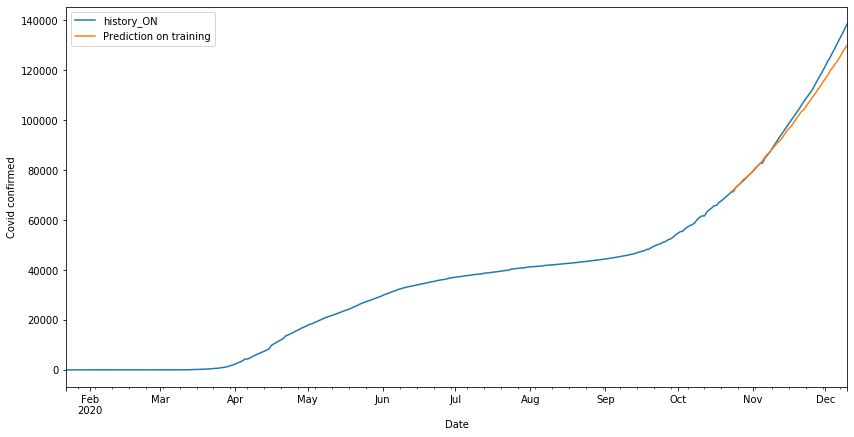

In [15]:
pred = results.get_prediction(start=pd.to_datetime('2020-10-23'),end=pd.to_datetime('2020-12-10'), dynamic=False)
pred_ci = pred.conf_int()
ax = df_on.plot()
pred.predicted_mean.plot(ax=ax, label='Prediction on training',figsize=(14, 7))
ax.set_xlabel('Date')
ax.set_ylabel('Covid confirmed')
plt.legend()
plt.show()

#### Model evaluation

MAPE of the new model is 0.022. Recall that MAPE of the model without seasonal patterns is 0.083. As expected, MAPE of the model with seasonal patterns is better than MAPE of the model without seasonal pattern, which indicates that seasonal patterns do help the projection of this time series data.

In [16]:
actual = df_test.values.reshape(-1)
forecast = pred.predicted_mean.values
mape = np.mean(np.abs(forecast - actual)/np.abs(actual))
mape

0.022074780701876733

### COVID-19 Projections of three cases

From the analysis of ARIMA models in the previous section, the optimal model is obtained to be ARIMA with seasonal patterns. The details of the model is also refered to the previous section. Because of its goodness of fitting the data, we use this model to forecast the projection of the base-case spread, which is the most likely to accurately forecast the future trend of COVID-19 cases.


In ARIMA model(statistical models), the confidence intervals of the predictions are also provided. Specifically in this case, we select a 5% of confidence interval.

The figure below illustrates the 100-day projections of three case spread after 2020 Oct 23. As predicted, the situation of COVID-19 in Ontario is likely to get worse due to the second wave of the pandemic. According to the base-case projection, the actual situation of the pandemic till Dec 10th is worse than the base-case projection. A possible reason is that the residents in Ontario tended to neglect the danger of the spread of COVID-19 after the first-time successful control of the virus.

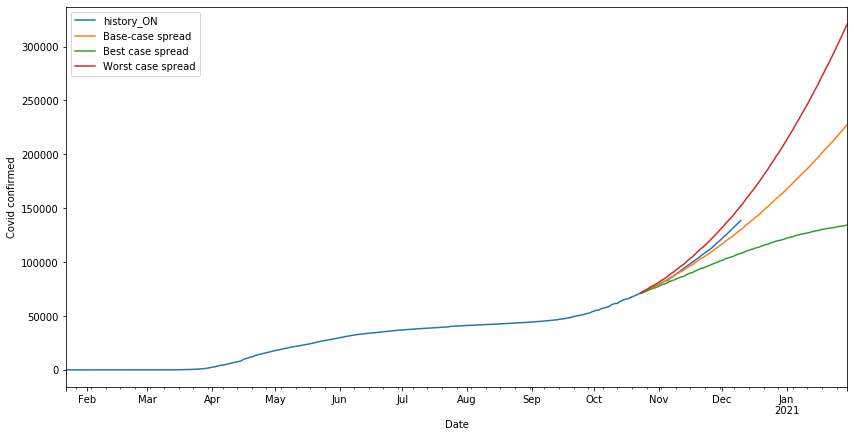

In [17]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = df_on.plot(figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Base-case spread')
pred_ci['lower history_ON'].plot(ax=ax, label='Best case spread')
pred_ci['upper history_ON'].plot(ax=ax, label='Worst case spread')
ax.set_xlabel('Date')
ax.set_ylabel('Covid confirmed')
plt.legend()
plt.show()

## Part 4. Relating COVID-19 Projections to a Second Dataset

The second dataset selected is "International travellers entering or returning to Ontario, seasonally adjusted". The content is about the number of different types of international travellers entering or returning to Ontario by month. By analysis of both datasets, it is expected to discover some relations bewteen Covid cases and international travellers so that some insights or ideas can be obtained with respect to the COVID-19 projections obtained from Part 3.

**Source: Statistics Canada. Table 24-10-0005-01 International travellers entering or returning to Canada, by province of entry, seasonally adjusted**

In [18]:
df2 = pd.read_csv('Traveller_Ontario.csv')
df2.index = df2['Traveller category']
df2.drop(['Traveller category'], axis = 1, inplace=True)
df2

,19-Nov,19-Dec,20-Jan,20-Feb,20-Mar,20-Apr,20-May,20-Jun,20-Jul,20-Aug,20-Sep
Traveller category,,,,,,,,,,,
Total non resident travellers,1371282,1417963,1393487,1379182,605734,54569,42326,45499,43813,53263,71215
United States travellers,1100438,1141759,1117653,1123393,487804,41072,36236,39176,35295,40888,55955
Travellers from countries other than United States,270844,276204,275834,255790,117929,13497,6090,6323,8518,12375,15260
Total Canadian travellers returning from abroad,2316500,2372424,2348636,2367382,1403526,104405,125576,183927,177600,179541,217611
Canadian travellers returning from United States,1798413,1845441,1827057,1848164,1046049,83736,110783,162387,149827,144963,182469
Canadian travellers returning from countries other than United States,518088,526984,521579,519219,357477,20669,14792,21540,27773,34578,35142


### Relate the Covid-19 history to the number of international travellers in Ontario

As shown in the figure below, the number of international travellers stayed high as normal before March, and there was almost no confirmed case in Ontario at that time. With the rising of pandemic in March, the number of international travellers entering Ontario has reduced significantly. In April, this number hit the lowest. However, since a lot of travellers has already entered Ontario, the number of the confirmed cases substantially increased the middle of April. This is one of the indicators that the number of international travellers can affect the spread of Covid 19. 

From May to September, the number of internatiolly travellers entering Ontario remained small. In this case, the pandemic got controlled and the number of confirmed cases had almost no increase, which also proved that travel restriction is significant in the precaution and control of Covid-19 pandemic.

Text(0, 0.5, 'Number of international travellers')

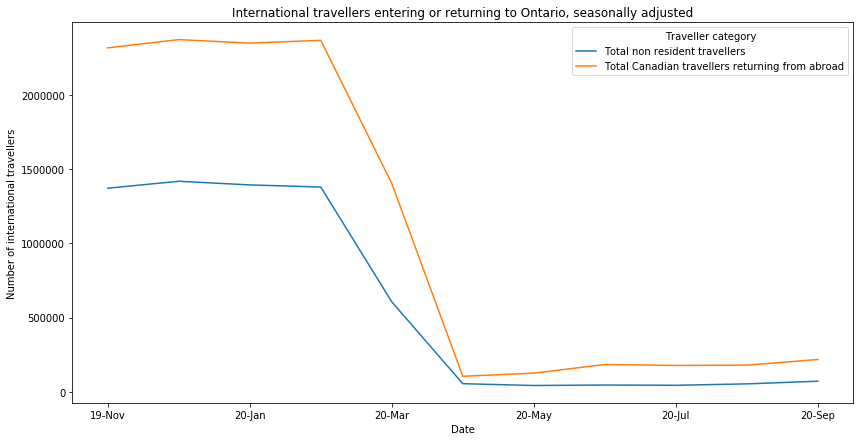

In [19]:
ax = df2.T[['Total non resident travellers','Total Canadian travellers returning from abroad']].plot(figsize=(14, 7),
                 title = 'International travellers entering or returning to Ontario, seasonally adjusted')
ax.set_xlabel("Date")
ax.set_ylabel("Number of international travellers")

### Relate the Covid-19 projections to the number of international travellers in Ontario

For the purpose of relating the projections of Covid-19 confirmed to the number of international travellers in Ontario, we focus on a more detailed plot from April to September. As shown, the number of Canadian travellers returning Ontario was approximately doubled in September compared to April, which could be one of the causes of second wave pandemic in Ontario. Furthermore, notice that most travellers entering or returning Ontario were from the US. Since it is worldwide known that the pandemic in the US was heavily severe, this could also be a source of second wave pandemic in Ontario. 

#### Conclusions

Referring to the Covid-19 projections from Part 3, the number of Covid-19 confirmed in the future would rise at a constant rate according to the base-case projection, or at an increasing rate according to the worst case projection. In both cases, the number of international travellers entering Ontario would surely decrease to a small value in order to control the pandemic. According to the best case projection, the pandemic would be successfully under control. In this different situation, the number of international travellers entering Ontario would also decrease, however, to a moderate value in case of more waves of pandemic. Particularly, the number of travellers entering from United States would also drop dramatically, if it is desirable for everyone that the future situation of COVID-19 gets better in Ontario. Nevertheless, since the actual situation of the pandemic till Dec 10th is worse than the base-case projection, it can be inferred that the actual number of international travellers in the future might be a bit larger than we thought, while still be smaller than before.

Text(0, 0.5, 'Number of international travellers')

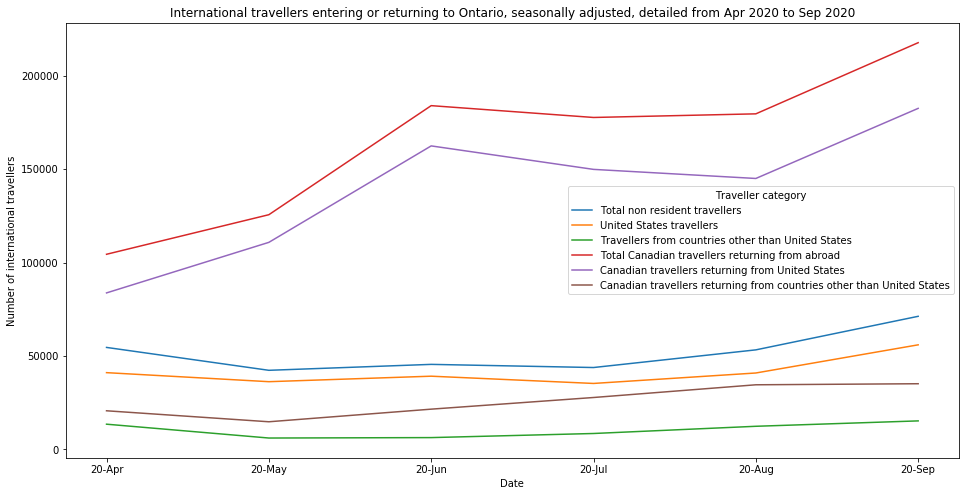

In [20]:
ax = df2.T.iloc[5:].plot(figsize=(16, 8),
                 title = 'International travellers entering or returning to Ontario, seasonally adjusted, detailed from Apr 2020 to Sep 2020')
ax.set_xlabel("Date")
ax.set_ylabel("Number of international travellers")

## Part 5. Deriving insights about policy and guidance to tackle the outbreak based on model findings

As discussed in Part 4, the outbreak of COVID-19 would not be controlled totally in the near future, while reducing the number of international travellers entering Ontario would have positive effects on the control of COVID-19. This insight is also demonstrated by the small number of total confirmed cases in British Columbia. Compared to the provinces in the east(i.e. Ontario and Quebec), there are a much smaller number of international travellers entering British Columbia which is located in the west. Thanks to this attribute, British Columbia has a better situation of COVID-19. Therefore, the inspection and supervision of international travellers would be a great factor that can help tackle the outbreak of COVID-19 in Ontario.

### Government

In order to tackle the outbreak of COVID-19 in Ontario, as suggested, the inspection and supervision of international travellers would be an important factor. Specifically, new policies with respect to the international travellers can be fourfold:

- Limit the number of international flights entering Ontario per week. This policy can reduce the number of international travellers from the source.
- All travellers are required to wear goggles, protection coats and face masks in order to strictly prevent the spread of virus during the flight.
- All travellers are required to quarantine in the hotels supervised by hospitals and the government for 14 days. The effectiveness of this policy has been proven by China where no Covid-19 case appears at all.
- For travellers from the US, only COVID test result one day before the flight is valid for entering Canada. More strict hygiene inspections are applied to the travellers from the US, since they are from one of the places that the pandemic is the most severe in the world.   

### Healthcare

In support of the new policies proposed above, doctors and nurses contribute to the hygiene inspections of travellers in quarantine in designated hotels. Specifically, they daily inspect all travellers for any symptoms of COVID-19. If any, the travellers will reexperience the 14-day quarantine once they recover. If any cases get worse, they will receive COVID test followed with appropriate therapy in the hospital.

### Industries

In support of the new policies proposed above, all related industries need to manufacture a greater number of hygiene equipment in aid of the inspection and supervision of international travellers.

### Professionals and scientists

In support of the control of COVID-19 from the factor of international travellers, professionals and scientists should conduct more analysis or experiments, such that the outcomes support the government propose more policies that can help fight the outbreak of the pandemic.